## Center's Centriol detection ##
This notebook compute method to find centers from our predicted masks. Also it diplayed images that we used for the report

In [1]:
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils

In [2]:
def get_mask_info(prediction_path, annotation_file_path, mask_pred_path, mask_gt_path):
    """
    This method return all necessary data we need according to our predictions
    
    argument :
        prediction_path : path to prediction masks names
        annotation_file_path : path to gt centers coordinate
        mask_pred_path : path to prediction masks
        mask_gt_path : path to gt masks
    
    return :
        pred_mask_list : all predicted mask image
        gt_mask_list : all ground truth mask image
        coords_list : all centers coordinate for each image
        coords_count_list : the number of centriols in each image
    """
    images_names = [f for f in os.listdir(prediction_path)]
    pred_mask_list = []
    gt_mask_list = []
    coords_list = []
    coords_count_list = []
    data = pd.read_csv(annotation_file_path)
    img_name, count_coords = np.unique(data['image_name'], return_counts=True)
    for name in images_names:
        print(name)
        pred_mask_list.append(cv2.imread(mask_pred_path + name))
        gt_mask_list.append(cv2.imread(mask_gt_path + name))
        d = data[data['image_name'] == name[:-9]]
        x = np.array(d['x'])
        y = np.array(d['y'])
        coords = np.stack((y, x), axis=1)
        coords_list.append(coords)
        coords_count_list.append(count_coords[img_name == name[:-9]])
    
    return pred_mask_list, gt_mask_list, coords_list, coords_count_list

In [3]:
prediction_path = "dataset/single-channel-images/predictions/full_experiment_single_channel/"
annotation_file_path = "dataset/raw-data/annotations.csv"
mask_pred_path = os.path.join('dataset/single-channel-images/predictions/full_experiment_single_channel/')
mask_gt_path = os.path.join('dataset/single-channel-images/masks/')

pred_mask_list, gt_mask_list, coords_list, coords_count_list = \
        get_mask_info(prediction_path, annotation_file_path, mask_pred_path, mask_gt_path)

RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_004_002_max_C3_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_002_001_max_C1_mask.png
RPE1wt_CP110+GTU88+PCNT_2_003_003_max_C1_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_001_001_max_C1_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_002_001_max_C1_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_004_002_max_C3_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_004_004_max_C3_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_000_003_max_C3_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_000_004_max_C2_mask.png
RPE1wt_CP110+GTU88+PCNT_2_004_000_max_C1_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_003_001_max_C2_mask.png
RPE1wt_CP110+GTU88+PCNT_2_003_004_max_C2_mask.png
RPE1wt_CP110+GTU88+PCNT_2_002_003_max_C2_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_002_001_max_C2_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_002_003_max_C1_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_000_000_max_C2_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_004_003_max_C1_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_003_000_max_C3_mask.png
RPE1wt_CP110+GTU88+PCNT_2_002_001_max_C1_

In [77]:
def compute_threshold_mask(mask, trsh):
    """
    Compute the process mask
    
    argument :
        mask : the mask to be process
        trsh : the global threshold quantity
        
    return :
        thresh : preprocess mask
    """
    
    image = mask.copy()
    image[image < trsh] = 0
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -10)
    return thresh

In [78]:
def find_center_coordinates(thresh):
    """
    Find coordinates of every blobs center found in the threshold mask
    
    argument :
        thresh : the threshold mask
        
    return : 
        centers_coords : all center found in the mask
    """
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    centers_coords = []
    for c in cnts:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m01"] / M["m00"])
            cY = int(M["m10"] / M["m00"])
            centers_coords.append(np.array((cX, cY)))
        else:
            centers_coords.append(np.array((-1, -1)))
            
    return np.array(centers_coords)

In [79]:
def assign_pred_center_to_gt(pred_coords, gt_coords):
    """
    Assign detected center to one ground truth coordinates if clos enough
    
    argument :
        pred_coords : the predicted center coordinates
        gt_coords : the ground truth coordinates
        
    return :
        assignment_list : list of indexes ([(0, 1), (1, 5), (3, 2)] meaning that gt center 0 is assign to predicted
                            center 1, gt center 1 to pred center 5, etc...)
    """
    
    assignment_list = []
    new_coords_centriol = np.array(pred_coords[pred_coords != [-1, -1]].reshape(-1, 2))
    temp_coords_centriol = new_coords_centriol.copy()
    for i, coord in enumerate(gt_coords):
        vx = coord[0] - temp_coords_centriol[:, 0]
        vy = coord[1] - temp_coords_centriol[:, 1]
        dist = np.linalg.norm(coord - temp_coords_centriol, axis=1)
        if dist.size != 0:
            min_dist = np.argmin(dist)
            if dist[min_dist] < 3:
                temp_coords_centriol[min_dist] = np.array((np.Inf, np.Inf))
                assignment_list.append((i, min_dist))
    return np.array(assignment_list)

In [80]:
def best_threshold_coord_nb(pred_masks, gt_masks, count_coords, gt_coords):
    """
    Find the best global threshold for all images
    
    argument : 
        pred_masks : list of predicted mask
        gt_masks : list of ground truth mask
        count_coords : list of the number of coordinates for each image
        gt_coords : list of ground truth coordinates
        
    return : 
        best_trsh : the best global threshold
        scores_track : for plot purpose, keep track of the recall
        scnd_track : for plot purpose, keep track of the precision
    """
    best_trsh = 0
    scores_track = []
    scores_track.append(0)
    scnd_track = []
    scnd_track.append(0)
    best_score = 0
    total_count = 0
    j = 0
    for trsh in range(0, 255):
        temp_count = 0
        scnd_count = 0
        for i, (pred, gt) in enumerate(zip(pred_masks, gt_masks)):
            if scnd_track[j] != 0:
                print("threshold : {:3}, {:2}/{:2}, percentage detected centriol {:3.3}, precision {:5}"\
                      .format(trsh, i, len(pred_masks), 100 * scores_track[j] / np.sum(count_coords), 100 * scores_track[j] / scnd_track[j]), end='\r')

            thresh = compute_threshold_mask(pred, trsh)
            centers_coords = find_center_coordinates(thresh)
            new_centers_coords = centers_coords[centers_coords != np.array((-1, -1))].reshape(-1, 2)
            assign_center = assign_pred_center_to_gt(centers_coords, gt_coords[i])
            scnd_count += len(new_centers_coords)
            temp_count += len(assign_center)
        
        scores_track.append(temp_count)
        scnd_track.append(scnd_count)
        if temp_count > best_score:
            best_trsh = trsh
            best_score = temp_count
            total_count = temp_count
        j += 1
    return best_trsh, scores_track, scnd_track

In [71]:
best_trsh, scores_track, scnd_track = best_threshold_coord_nb(pred_mask_list, gt_mask_list, coords_count_list, coords_list)

/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0.8503336510962822 0.8495238095238096


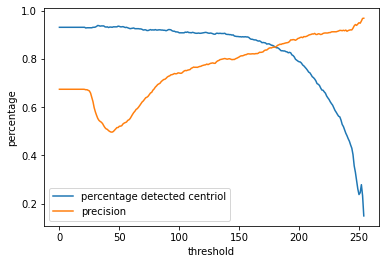

In [72]:
plt.plot(np.arange(len(scores_track) - 1) + 0, (scores_track[1:] / np.sum(coords_count_list)), label='percentage detected centriol')
plt.plot(np.arange(len(scores_track) - 1) + 0, (np.array(scores_track[1:]) / np.array(scnd_track[1:])), label='precision')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('percentage')
crossing = np.argmin(np.abs((scores_track[1:] / np.sum(coords_count_list) - np.array(scores_track[1:]) / np.array(scnd_track[1:]))))
plt.savefig('figs/threshold_parameters.png')
print((scores_track[1:] / np.sum(coords_count_list))[crossing], (np.array(scores_track[1:]) / np.array(scnd_track[1:]))[crossing])

In [81]:
best_trsh = crossing
print(best_trsh)

180


In [54]:
#Redefine the method to output several things for ploting purpose
def compute_threshold_mask2(mask, trsh):
    image = mask.copy()
    image[image < trsh] = 0
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray.copy(), (3, 3), 0)
    thresh = cv2.adaptiveThreshold(blurred.copy(), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -10)
    return thresh, blurred, gray, image

In [55]:
img_nb = 0
clean_mask_list = []
for img in pred_mask_list:
    thresh = compute_threshold_mask(img, best_trsh)
    clean_mask_list.append(thresh)
center_centriol = find_center_coordinates(clean_mask_list[img_nb])
for i, cm in enumerate(clean_mask_list):
    clean_mask_list[i] = np.repeat(cm[:, :, np.newaxis], 3, axis=2)

center_centriol_re = center_centriol[center_centriol != np.array((-1, -1))].reshape(-1, 2)
assign_center = assign_pred_center_to_gt(center_centriol, coords_list[img_nb])
detect_centri_full = center_centriol_re.copy() #[assign_center[:, 1]]
print("IMAGE NUMBER : ", img_nb)
print("total center detected : ", len(detect_centri_full))
detect_centri = center_centriol_re[assign_center[:, 1]].copy() #[assign_center[:, 1]]
print("assign center to gt_center : ", len(detect_centri_full[assign_center[:, 1]]))
print("gt_center : ", len(coords_list[img_nb]))
print("precision : ", len(detect_centri) / len(detect_centri_full))
print("Recall : ", len(detect_centri) / len(coords_list[img_nb]))
gt_centri = coords_list[img_nb].copy() #[assign_center[:, 0]]

IMAGE NUMBER :  0
total center detected :  50
assign center to gt_center :  36
gt_center :  46
precision :  0.72
Recall :  0.782608695652174


## Cell below show the evolution of the processing algo

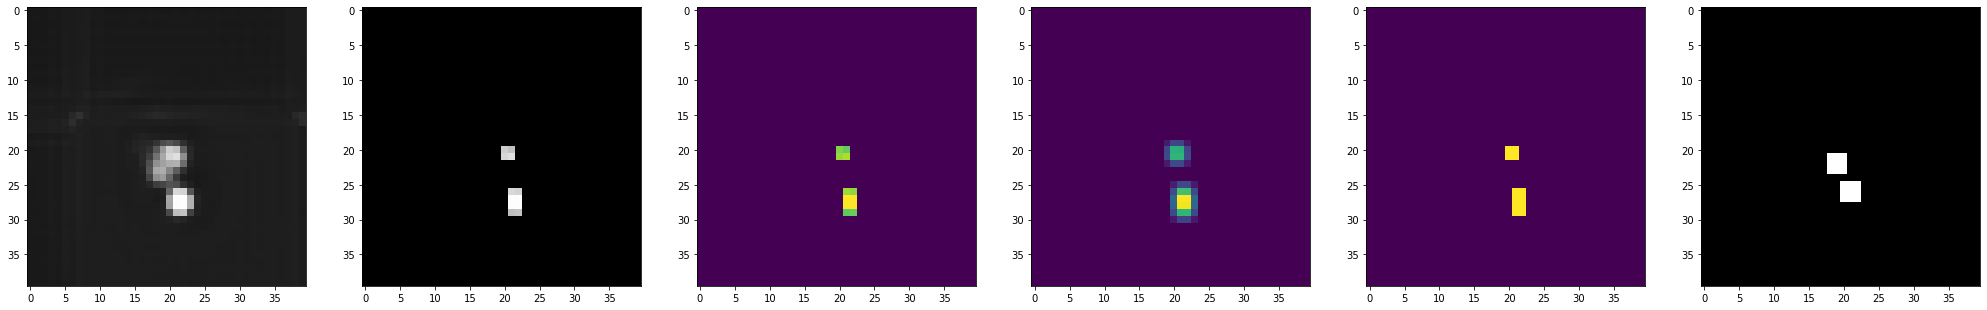

In [60]:
point = detect_centri[15]
window_size = 20
range_lx = np.maximum(point[0] - window_size, 0)
range_ux = np.minimum(point[0] + window_size, 2048)
range_ly = np.maximum(point[1] - window_size, 0)
range_uy = np.minimum(point[1] + window_size, 2048)

thresh, blurred, gray, image = compute_threshold_mask2(pred_mask_list[img_nb], best_trsh)

fig, ax = plt.subplots(1, 6, figsize=(35, 35))
ax[0].imshow(pred_mask_list[img_nb][range_lx:range_ux, range_ly:range_uy])
ax[1].imshow(image[range_lx:range_ux, range_ly:range_uy])
ax[2].imshow(gray[range_lx:range_ux, range_ly:range_uy])
ax[3].imshow(blurred[range_lx:range_ux, range_ly:range_uy])
ax[4].imshow(thresh[range_lx:range_ux, range_ly:range_uy])
ax[5].imshow(gt_mask_list[img_nb][range_lx:range_ux, range_ly:range_uy])

# Cell below show detected center #
### In red : detected center
### In blue : ground truth center
### In green : if detect center and ground truth are the same

/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


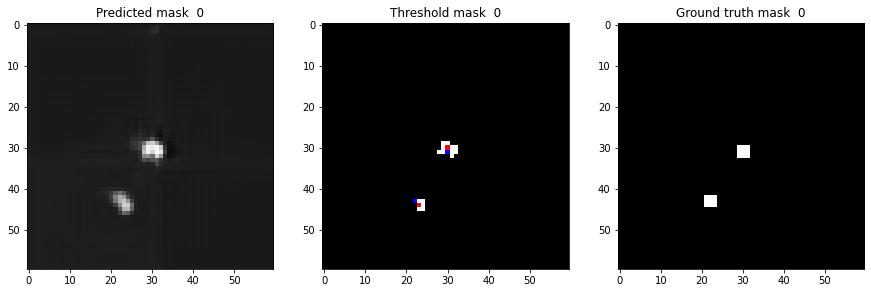

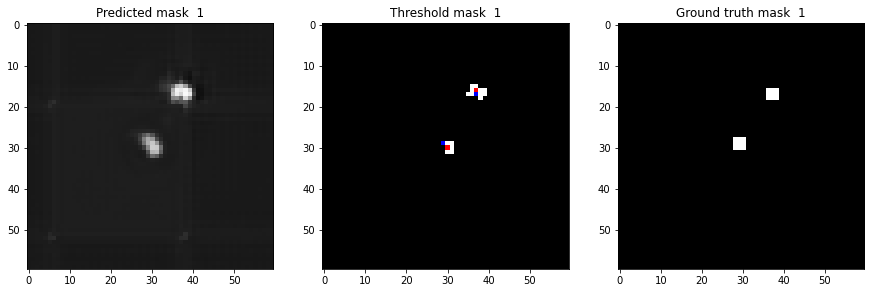

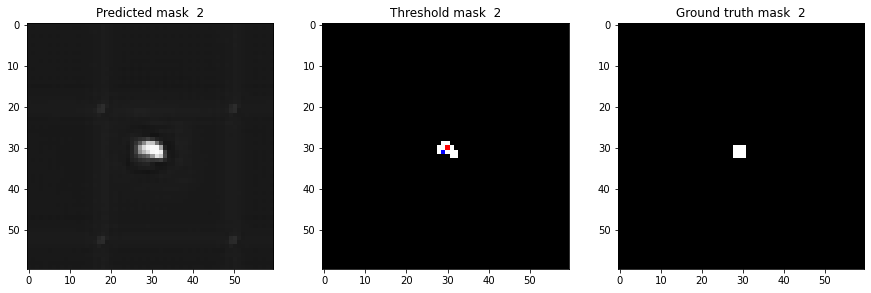

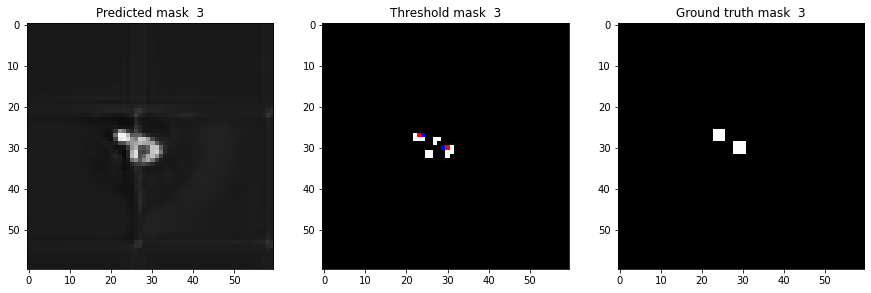

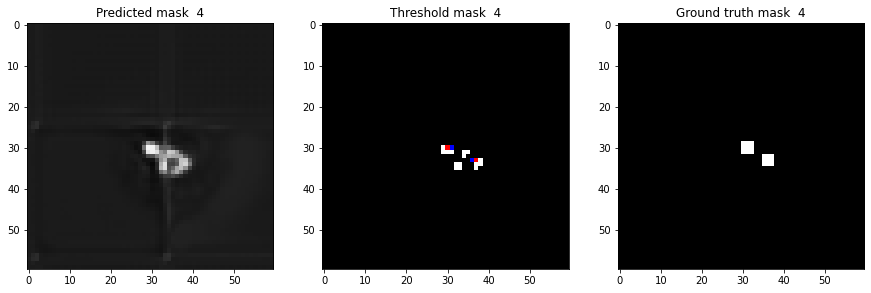

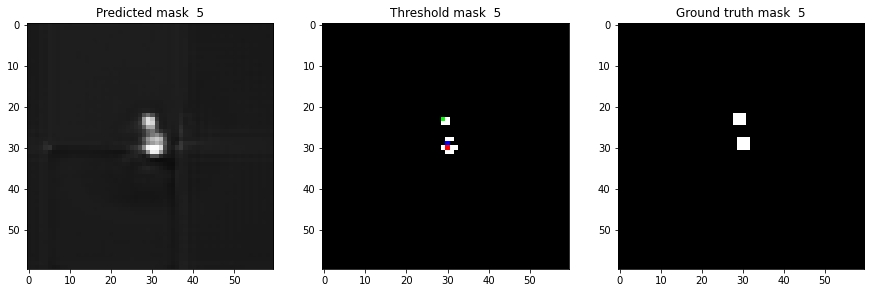

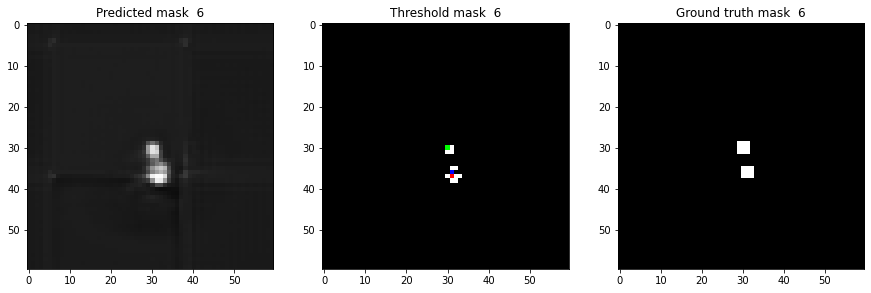

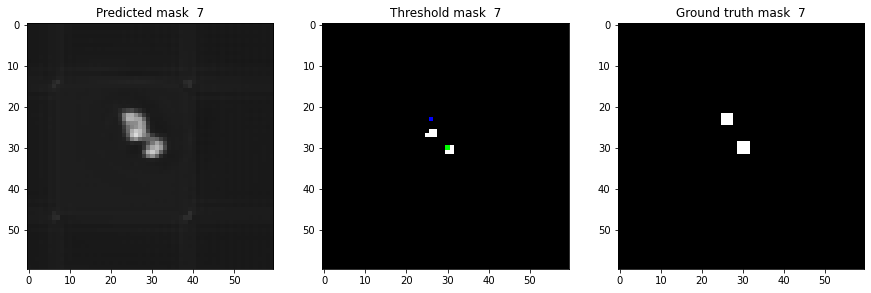

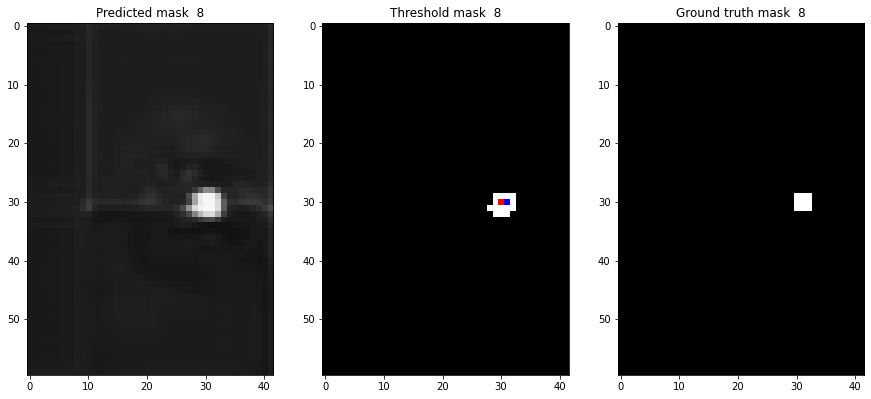

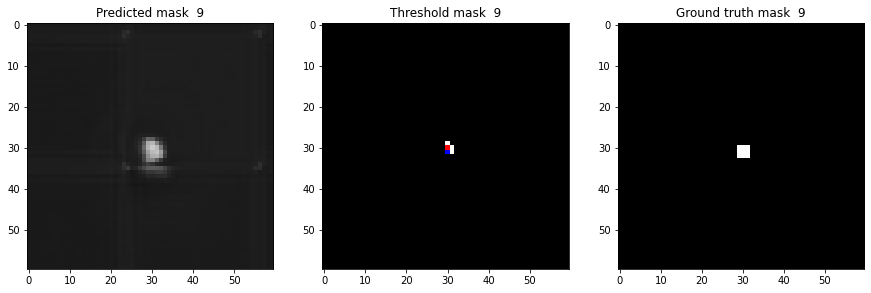

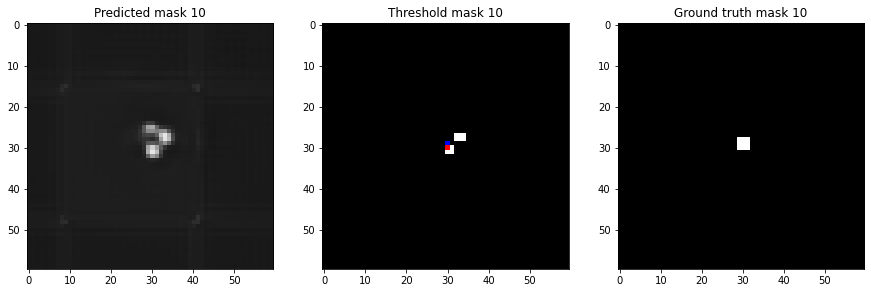

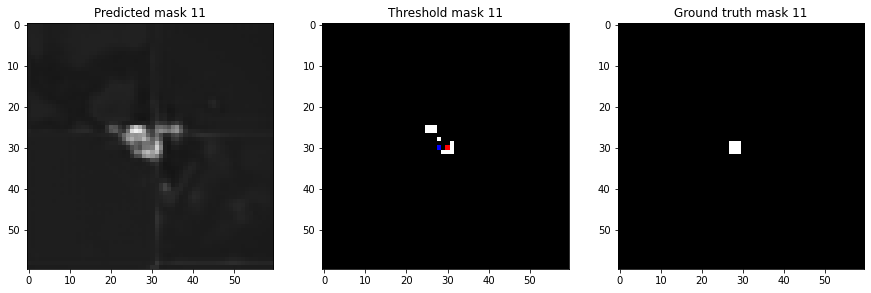

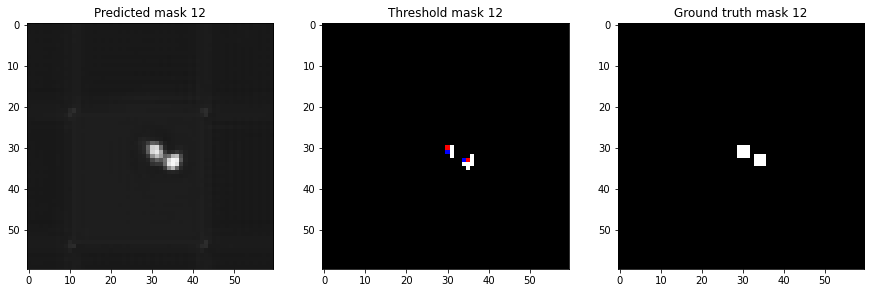

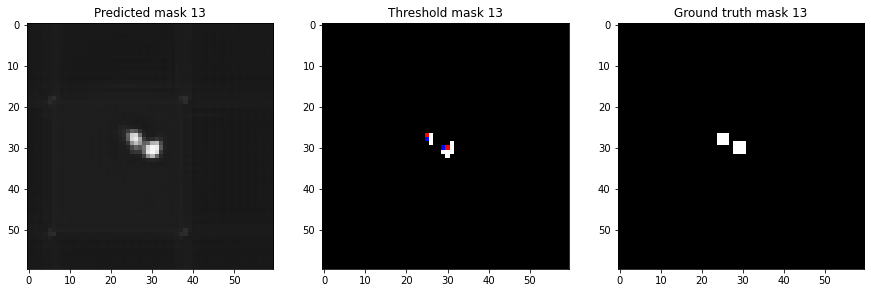

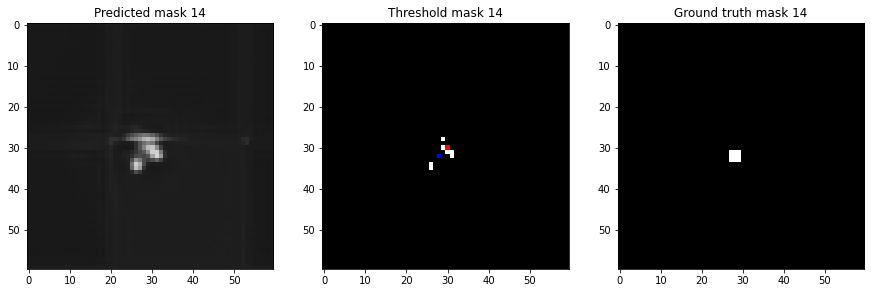

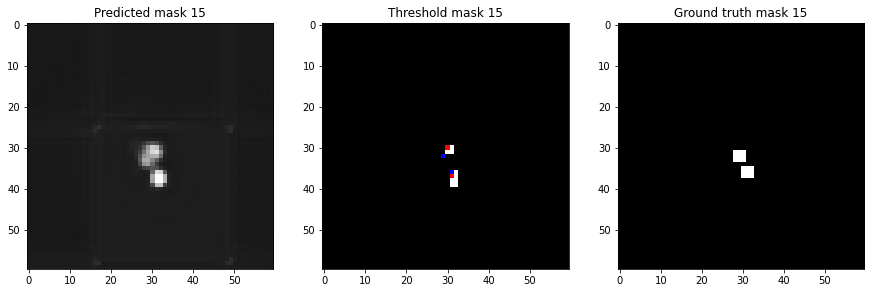

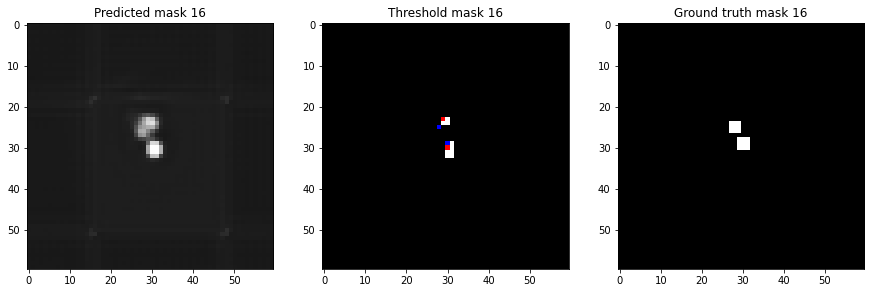

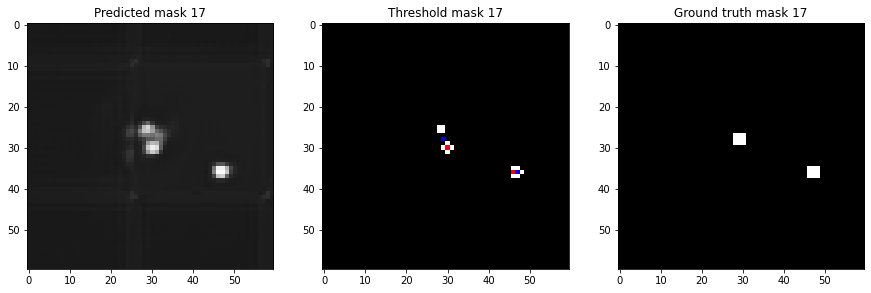

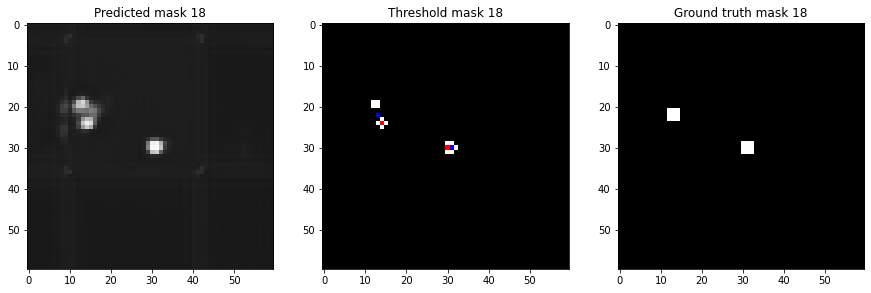

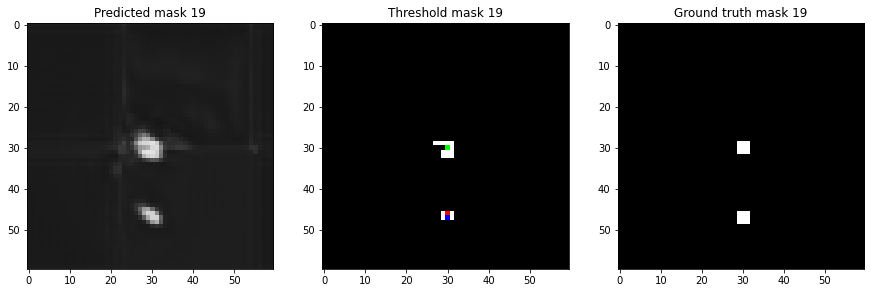

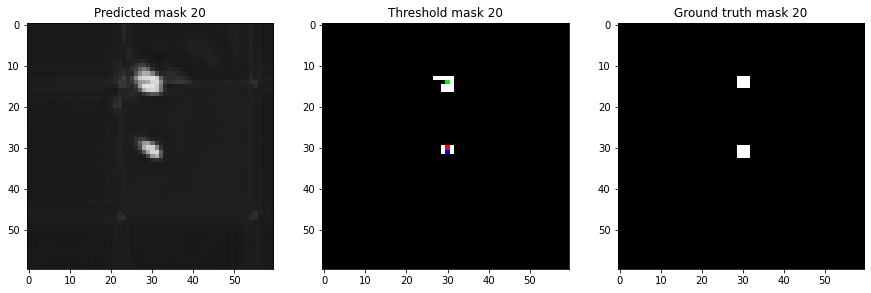

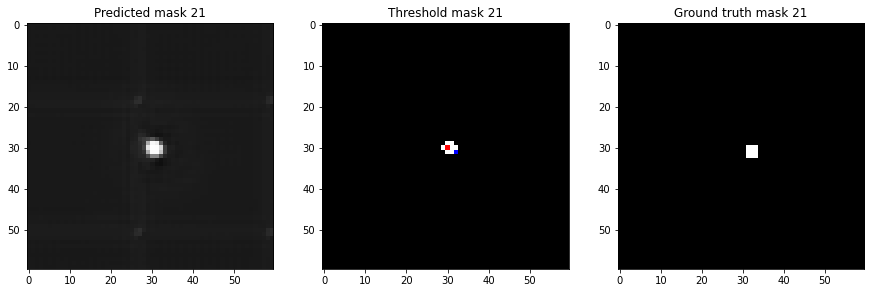

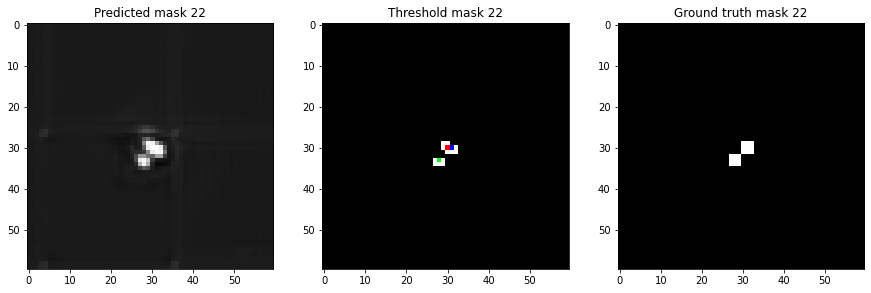

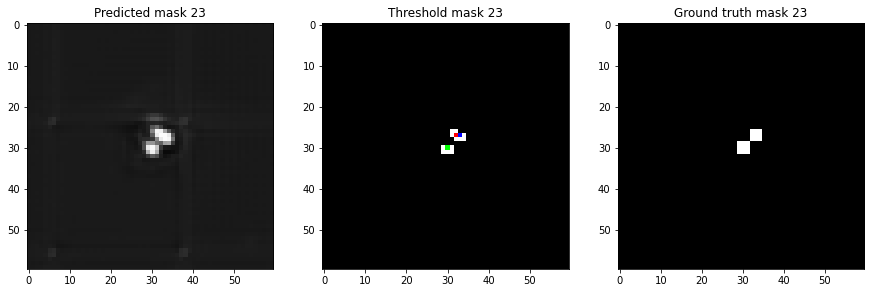

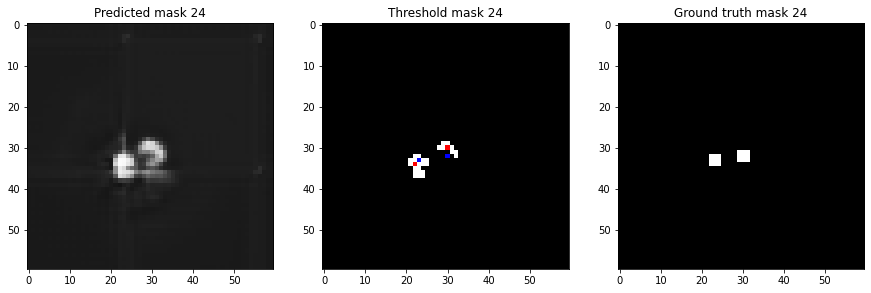

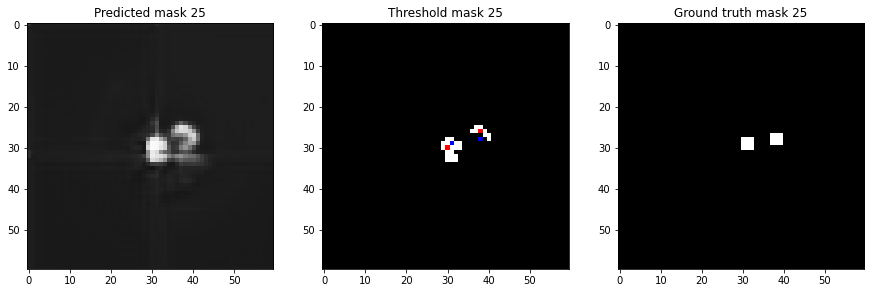

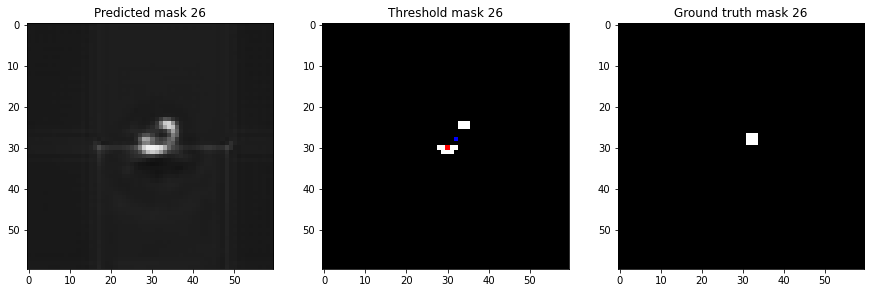

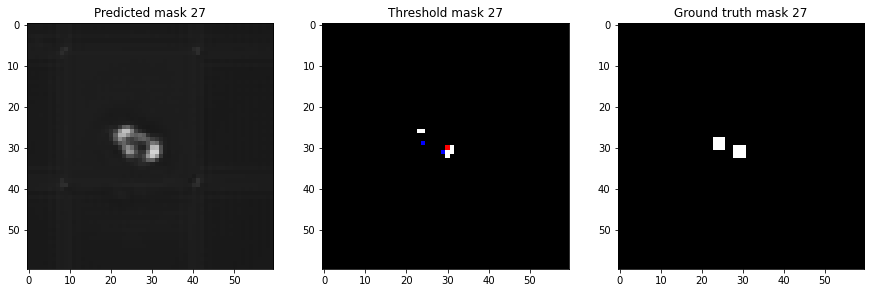

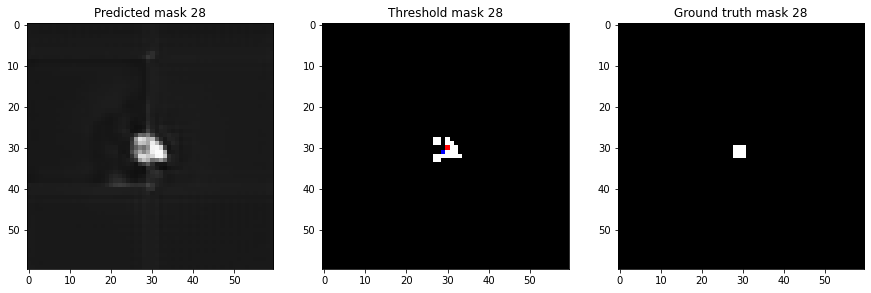

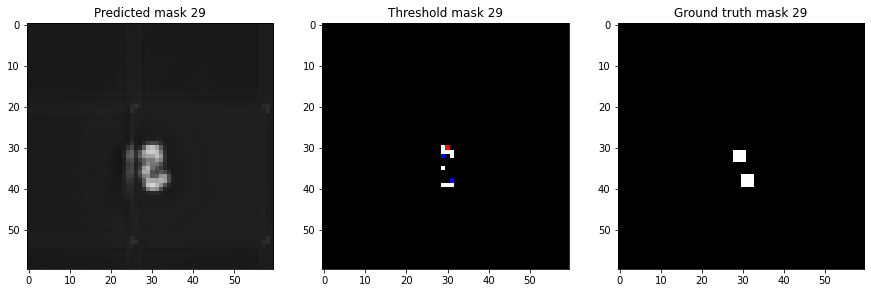

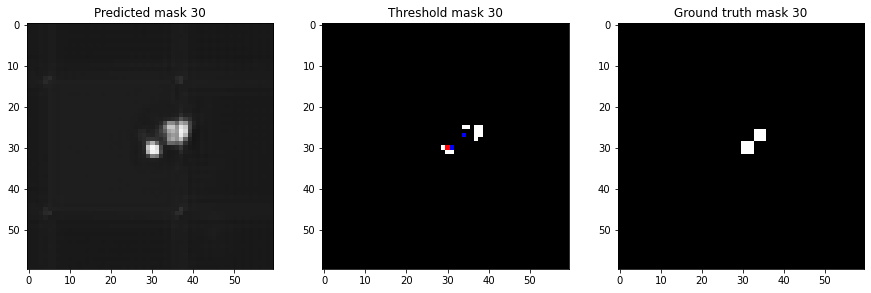

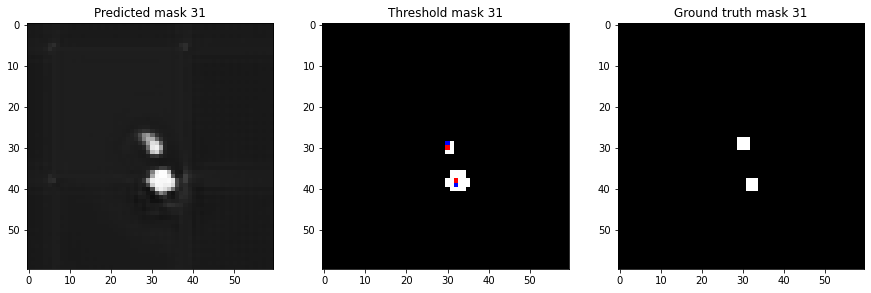

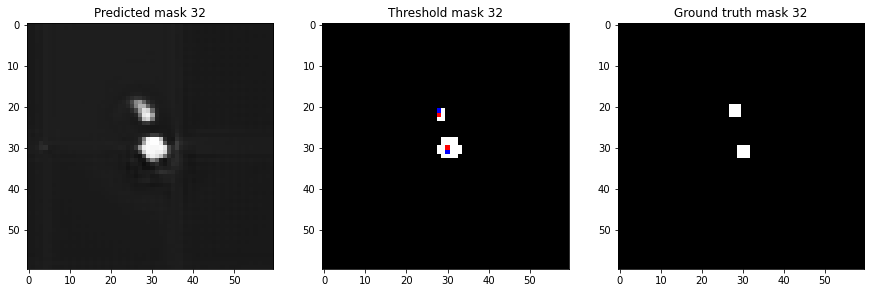

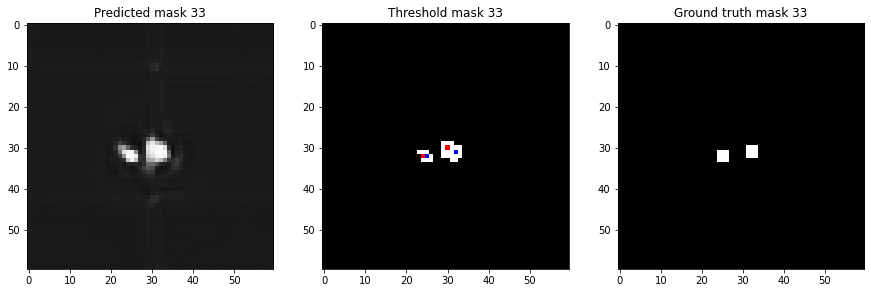

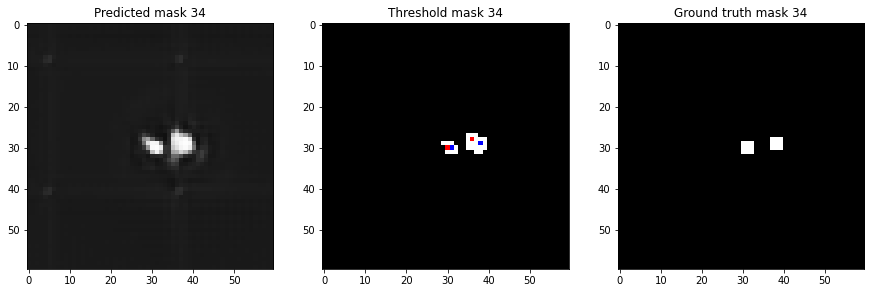

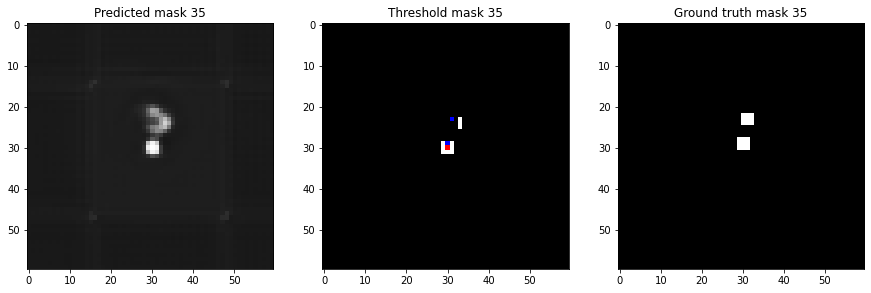

In [50]:
window_size = 30
new_clean_mask = clean_mask_list[img_nb].copy()
for gt_coord in gt_centri:
    new_clean_mask[gt_coord[0], gt_coord[1]] = np.array((0, 0, 255))
for i, coord in enumerate(detect_centri):
    if (np.any(np.argwhere(coord[0] == gt_centri[:, 0]) == np.argwhere(coord[1] == gt_centri[:, 1]))):
        new_clean_mask[coord[0], coord[1]] = np.array((0, 255, 0))
    else:
        new_clean_mask[coord[0], coord[1]] = np.array((255, 0, 0))
for point_idx in range(len(detect_centri)):
    fig, ax = plt.subplots(1, 3, figsize=(15,15))
    ax[0].imshow(pred_mask_list[img_nb][np.maximum(detect_centri[point_idx, 0] - window_size, 0) : detect_centri[point_idx, 0] + window_size, np.maximum(detect_centri[point_idx, 1] - window_size, 0) : detect_centri[point_idx, 1] + window_size])
    ax[1].imshow(new_clean_mask[np.maximum(detect_centri[point_idx, 0] - window_size, 0) : detect_centri[point_idx, 0] + window_size, np.maximum(detect_centri[point_idx, 1] - window_size, 0) : detect_centri[point_idx, 1] + window_size])
    ax[2].imshow(gt_mask_list[img_nb][np.maximum(detect_centri[point_idx, 0] - window_size, 0) : detect_centri[point_idx, 0] + window_size, np.maximum(detect_centri[point_idx, 1] - window_size, 0) : detect_centri[point_idx, 1] + window_size])
    ax[0].set_title("Predicted mask {:2}".format(point_idx))
    ax[1].set_title("Threshold mask {:2}".format(point_idx))
    ax[2].set_title("Ground truth mask {:2}".format(point_idx))
    fig.show()